##### Homework 2

Due: Tuesday March 1, 11:59pm

Late deadline (50\% off): Thursday March 3, 11:59pm

Name: Dani Song

NetID: ds2288


## Instructions
Read through this python notebook. You will be asked questions and given programming tasks. These are numbered, followed by point values for grading (for example, "Question 17.8 (5pt)"). You should edit the notebook directly to input your solution code and question answers. You can double click on text to edit it, which you should use for putting your question answers in the notebook.

When you are ready to submit, you should run all of your code (click Cell->Run All). Then you should submit **three** files to gradescope:
* PDF: export to PDF (click File->Download as->PDF via LaTeX)
* .py: export to Python (click File->Download as->Python (.py))
* .ipynb: submit the edited Jupyter Notebook


# Core Probabilistic Routines
You will be using the following helper functions for manipulating probability distributions.

Recall from lecture that you should represent probabilities as the logarithm of the probability. Whenever you want to multiply probabilities, instead you just add the log probabilities. Whenever you want to add probabilities, instead you just `log_sum_exp` the log probabilities. Whenever you want to add a list of probabilities, instead you just `log_sum_exp_list` the list of log probabilities.

Generally in this homework we will be representing distributions over a random variable $X$ by dictionary mapping $x$ to $\log P(X=x)$. 

In [500]:
from math import exp, isinf
import math
import numpy as np
import matplotlib.pyplot as plt
from time import time


def log(x):
    if x==0.:
        return float("-inf")
    return math.log(x)

def sample_from_log_distribution(distribution):
    """
    distribution: a dictionary mapping x to log P(x)
    stochastically draws a sample from the distribution P(x)
    """
    distribution = list(distribution.items())
    values = [v for v, _ in distribution ]
    probabilities = np.array([exp(log_prob) for _, log_prob in distribution ])
    result = np.random.multinomial(1, probabilities)
    for v, r in zip(values, result):
        if r:
            return v

    assert False
    
def log_sum_exp(first_log_probability, second_log_probability):
    """
    Returns log(exp(first_log_probability) + exp(second_log_probability))
    Does so in a numerically stable way
    """
    if isinf(first_log_probability) and first_log_probability<0:
        return second_log_probability
    if isinf(second_log_probability) and second_log_probability<0:
        return first_log_probability
    larger, smaller = max(first_log_probability, second_log_probability), min(first_log_probability, second_log_probability)
    return larger + log(1 + exp(smaller-larger))

def log_sum_exp_list(lst):
    """
    Returns log(sum(exp(log_probability) for log_probability in lst))
    Does so in a numerically stable way
    """
    total=float("-inf")
    for log_probability in lst:
        total = log_sum_exp(total, log_probability)
    return total

def norm_log_distribution(distribution):
    """
    distribution is a dictionary mapping x to log (alpha * P(x))
    where alpha is a normalization constant
    returns a dictionary mapping x to log P(x), ie a normalized distribution
    Does so in a numerically stable way
    """
    normalizer = log_sum_exp_list(list(distribution.values()))
    return {x: log_probability - normalizer
            for x, log_probability in distribution.items()}

def expectation(distribution, f):
    """
    f is a function from x to a real number
    distribution is a dictionary mapping x to log P(x)
    returns the expectation of f under the distribution P
    """
    return sum( f(x)*exp(log_probability)
                for x, log_probability in norm_log_distribution(distribution).items() )



# Alarm Network
You will be implementing and experimenting with the alarm network given in class, which is diagrammed below.
<center>
<img src="https://www.researchgate.net/profile/Alireza-Khanteymoori/publication/278673563/figure/fig1/AS:294244133687301@1447164676400/An-example-of-a-Bayesian-network.png" width="500">
</center>

First we represent the distribution over burglary with a dictionary mapping values of the burglary random variable to the log probability of that burglary value:

In [501]:
burglary_distribution = {True: log(0.001), False: log(1-0.001)}

Then we do the same thing for earthquake:

In [502]:
earthquake_distribution = {True: log(0.002), False: log(1-0.002)}

Because alarm is directly caused by burglary and earthquake, we represent its conditional distribution as a function that inputs burglary and earthquake. The `alarm_distribution` function returns the probability distribution over whether the alarm goes off, given those inputs.

In [503]:
def alarm_distribution(burglary, earthquake):
    if burglary and earthquake: return {True: log(0.95), False: log(1-0.95)}
    if burglary and not earthquake: return {True: log(0.94), False: log(1-0.94)}
    if not burglary and earthquake: return {True: log(0.29), False: log(1-0.29)}
    if not burglary and not earthquake: return {True: log(0.001), False: log(1-0.001)}

## Task 1.1 Defining the rest of the network (1pt)
Implement `mary_distribution` and `john_distribution`, which should be functions that take the setting of `alarm` (either `True` or `False`) and which return a dictionary mapping the setting of MaryCalls/JohnCalls (either `True` or `False`) to a log probability. This should be analogous to `alarm_distribution`.

In [504]:
def mary_distribution(alarm):
    if alarm: return {True: log(0.70), False: log(1-0.70)}
    if not alarm: return {True: log(0.01), False: log(1-0.01)}
def john_distribution(alarm):
    if alarm: return {True: log(0.90), False: log(1-0.90)}
    if not alarm: return {True: log(0.05), False: log(1-0.05)}

## Task 1.2 Defining the joint distribution (2pt)
Implement `log_joint`. Its arguments are settings of the random variables (`burglary`, `earthquake`, `alarm`, `mary`, `john`). It should return the logarithm of the joint probability of that variable assignment: 
$$\log P(\text{Burglary=burglary, Earthquake=earthquake, Alarm=alarm, MaryCalls=mary, JohnCalls=john})$$

Your implementation of `log_joint` should use `burglary_distribution`, `earthquake_distribution`, `alarm_distribution`, `mary_distribution`, and `john_distribution`.

In [505]:
def log_joint(burglary, earthquake, alarm, mary, john):
    return burglary_distribution[burglary] + earthquake_distribution[earthquake] + \
    alarm_distribution(burglary, earthquake)[alarm] + mary_distribution(alarm)[mary] + john_distribution(alarm)[john]

## Task 1.3 Calculate $\log P(\text{Mary=True, John=True})$ (2pt)
Using `log_sum_exp_list` and `log_joint`, calculate $\log P(\text{Mary=True, John=True})$.
Store this calculation result in the variable `mary_and_john`.

Hint: you might want to try a *list comprehension* that looks like:

`[ ... for burglary in [True, False] for earthquake in [True, False] for alarm in [True, False] ]`

Alternatively you could use three nested `for` loops to iterate over all possible variable assignments to earthquake, burglary, and alarm.

In [506]:
mary_and_john = log_sum_exp_list([log_joint(burglary, earthquake, alarm, True, True) for burglary in [True, False] \
                                  for earthquake in [True, False] for alarm in [True, False]])
print("P(John=True, Mary=True) =", exp(mary_and_john))

P(John=True, Mary=True) = 0.0020841002390000014


## Task 1.4 More calculations (2pt)
Similarly, calculate $\log P(\text{Burglar=True, Mary=True, John=True})$ and $\log P(\text{Burglar=False, Mary=True, John=True})$. Put these quantities into the variables `burglary_and_mary_and_john` and `not_burglary_and_mary_and_john`.

In [507]:
burglary_and_mary_and_john = log_sum_exp_list([log_joint(True, earthquake, alarm, True, True) \
                                               for earthquake in [True, False] for alarm in [True, False]])
not_burglary_and_mary_and_john = log_sum_exp_list([log_joint(False, earthquake, alarm, True, True) \
                                                   for earthquake in [True, False] for alarm in [True, False]])
print("log P(Burglar=True, John=True, Mary=True) =", burglary_and_mary_and_john)
print("log P(Burglar=False, John=True, Mary=True) =", not_burglary_and_mary_and_john)

log P(Burglar=True, John=True, Mary=True) = -7.4315942266119235
log P(Burglar=False, John=True, Mary=True) = -6.507733191269771


## Task 1.5 Calculate posterior $P(\text{Burglar=True}|\text{Mary=True, John=True})$ (1pt)
Write down a single line of code which will calculate and print out $P(\text{Burglar=True}|\text{Mary=True, John=True})$. You should reuse `burglary_and_mary_and_john` and `mary_and_john`.
Hint: Use Bayes rule to relate $P(\text{Burglar=True}|\text{Mary=True, John=True})$ to $P(\text{Burglar=True}, \text{Mary=True, John=True})$ and $P(\text{Mary=True, John=True})$.

In [508]:
print(burglary_and_mary_and_john)
print("P(Burglar=True|John=True, Mary=True) =", exp(burglary_and_mary_and_john - mary_and_john))

-7.4315942266119235
P(Burglar=True|John=True, Mary=True) = 0.2841718353643928


## Task 1.6 Another calculation for $P(\text{Burglar=True}|\text{Mary=True, John=True})$ (2pt)
Construct an unnormalized distribution over Burglar, conditioned on both Mary and John calling.
Store this inside the variable `unnormalized_log_posterior`, which should be a dictionary. The dictionary entry `unnormalized_log_posterior[b]` should be the logarithm of a probability that is proportional to $P(\text{Burglar=b} | \text{Mary=True, John=True})$.

Normalize this distribution (`unnormalized_log_posterior`) by calling `norm_log_distribution`, and store the result inside a new variable called `log_posterior`.
The dictionary entry `log_posterior[b]` should be the logarithm of $P(\text{Burglar=b}| \text{Mary=True, John=True})$.

In [509]:
unnormalized_log_posterior = {True: burglary_and_mary_and_john, False: not_burglary_and_mary_and_john} 
log_posterior = norm_log_distribution(unnormalized_log_posterior)
print("log P(Burglar|John=True, Mary=True) =", log_posterior)
print("P(Burglar=True|John=True, Mary=True) =", exp(log_posterior[True]))

log P(Burglar|John=True, Mary=True) = {True: -1.258176169692387, False: -0.3343151343502342}
P(Burglar=True|John=True, Mary=True) = 0.2841718353643928


Noticed that you have now calculated $P(\text{Burglar=True}|\text{Mary=True, John=True})$ twice, in two different ways. You should get the same result both times.

## Explaining Away

### Task 1.7 Programming (1pt)
Calculate and print out $P(\text{Burglar=True}|\text{Mary=True, John=True, Earthquake=True})$. 

In [510]:
mary_and_john_and_earthquake = log_sum_exp_list([log_joint(burglary, True, alarm, True, True) \
                                                 for burglary in [True, False] for alarm in [True, False]])
burglary_and_mary_and_john_and_earthquake = log_sum_exp_list([log_joint(True, True, alarm, True, True) \
                                                              for alarm in [True, False]])
print("P(Burglar=True|Mary=True, John=True, Earthquake=True) =", 
      exp(burglary_and_mary_and_john_and_earthquake - mary_and_john_and_earthquake)) 

P(Burglar=True|Mary=True, John=True, Earthquake=True) = 0.0032622416021499314


### Question 1.8 (1pt)
Why did the probability of burglary go down given Mary and John calling, after we conditioned on the earthquake happening?

* **Solution: Because the probability of burglary happening simultenously to an earthquake is lower than burglary or earthquake happening alone.** 

# Hidden Markov Model

You will be implementing and experimenting with the Hidden Markov Model (HMM) given in class, which is diagrammed below.

<center>
<img src="https://www.cs.cornell.edu/~ellisk/res/hmm.png" width="800">

</center>

The next Jupyter Notebook cell contains an implementation of Hidden Markov Model in the class `HMM`. You will be filling out parts of this implementation.

## Task 2.1 Simulating from the Bayesian Network (5pt)
Implement `sample_from_model`. You should use the method `sample_observation_given_state` for drawing from $P(X_t|Z_t)$, and the function `sample_from_log_distribution` for drawing from $P(Z_{t+1}|Z_{t})$ and for drawing from $P(Z_{1})$.

**You should first sample from $P(Z_{1})$, then $P(X_1|Z_1)$, then $P(Z_{2}|Z_{1})$, then $P(X_2|Z_2)$, then $P(Z_{3}|Z_{2})$, then $P(X_{3}|Z_{3})$, etc.** You could sample in other orders, but please do it in this order so that your results are identical to the reference results.
 

## Task 2.2 Calculating the forward distribution $P(Z_t|X_{1:t})$ (10pt)

Implement the forward algorithm for calculating $P(Z_t|X_{1:t})$. Do so within the method `forward`, and implement the API described in the docstring (*remember to calculate log probabilities, and your solution should linear time*)

## Task 2.3 Calculating the backward distribution $P(X_{t+1:T}|Z_t)$ (10pt)

Implement the backward algorithm for calculating $P(X_{t+1:T}|Z_t)$. Do so within the method `backward`, and implement the API described in the docstring (*remember to calculate log probabilities, and your solution should linear time*)

## Task 2.4 Calculating the forward/backward (smoothing) distribution $P(Z_t|X_{1:T})$ (5pt)

Implement the forward/backward algorithm for calculating $P(Z_t|X_{1:T})$. Do so within the method `forward_backward`, and implement the API described in the docstring (*remember to calculate log probabilities, and your solution should linear time*)

## Calculating the marginal likelihood $P(X_{1:T})$

### Task 2.5.1  (10pt)
Derive an expression for $P(X_{1:T})$ in terms of $P(Z_1)$, $P(X_1|Z_1)$, and the "backward" distribution $P(X_{2:T} | Z_1)$.
Write down the resulting equation for $P(X_{1:T})$.

**Your equation here (doubleclick on Jupyter notebook box to edit):** 
* $$P(X_{1:T})= P(Z_1)P(X_1|Z_1)P(X_{2:T} | Z_1)$$

### Task 2.5.2 (5pt)
Implement the `marginal_likelihood` method of `HMM`, which calculates $\log P(X_{1:T})$. You should use the equation that you derived in the previous part, together with your implementation of `backward`.

In [511]:
class HMM:
    def __init__(self, state_space, transition_distribution, initial_state_distribution):
        """
        state_space: list of possible values that each hidden state (Z_t) can assume
        transition_distribution: representation of log P(Z_{t+1} | Z_t).
           Should be a dictionary of dictionaries where:
           `transition_distribution[state_t][state_{t+1}] = log P(Z_{t+1}=state_{t+1} | Z_{t}=state_t)`
        initial_state_distribution: representation of log P(Z_1).
           Should be a dictionary where `initial_state_distribution[state_1] = log P(Z_1=state_1)`
        """
        self.state_space, self.transition_distribution, self.initial_state_distribution =\
             state_space, transition_distribution, initial_state_distribution

        normalizing_constant = log_sum_exp_list(list(initial_state_distribution.values()))
        if abs(normalizing_constant)>1e-5:
            assert False, f"Your initial state distribution is not normalized. Remembered that it should contain log \
            probabilities."

        for s in state_space:
            normalizing_constant = log_sum_exp_list([self.transition_distribution[s][next_state]
                                                     for next_state in state_space])
            if abs(normalizing_constant)>1e-5:
                assert False, f"Your transition distribution is not normalized. Remembered that it should contain \
                log probabilities. It is not normalized for state {s}"
        

        self.forward_dynamic_programming = {}
        self.backward_dynamic_programming = {}
        
    def logProb_observation_given_state(self, observation, state):
        """
        calculates log P(X_t=observation | Z_t=state)
        """
        assert False, "should be defined by the class inheriting from HMM"

    def sample_observation_given_state(self, state):
        """
        stochastically draws a sample from P(X_t | Z_t=state)
        """
        assert False, "should be defined by the class inheriting from HMM"

    def sample_from_model(self, time_steps):
        """
        Returns a sample from the generative model, not conditioned on anything
        The sample consists of both a list of observations and a list of hidden states
        Both of these lists should have length `time_steps`
        Return the pair (Z_{1:T}, X_{1:T})
        
        You should call out to the method `sample_observation_given_state`, 
          which will be implemented by classes inheriting from HMM
          
        ***You should first sample from $P(Z_{1})$, then $P(X_1|Z_1)$,
                                   then $P(Z_{2}|Z_{1})$, then $P(X_2|Z_2)$, 
                                   then $P(Z_{3}|Z_{2})$, then $P(X_{3}|Z_{3})$, 
                                   etc.
        You could sample in other orders, but please do it in this order!
        This ensures that your results are identical to the reference results.***
        """
        state = []
        observation = []
        
        prev_state = sample_from_log_distribution(self.initial_state_distribution)
        prev_observation = self.sample_observation_given_state(prev_state)
        state.append(prev_state)
        observation.append(prev_observation)
        
        for i in range(time_steps - 1):
            curr_state = sample_from_log_distribution(self.transition_distribution[prev_state])
            curr_observation = self.sample_observation_given_state(curr_state)
            state.append(curr_state)
            observation.append(curr_observation)
            prev_state = curr_state
        
        return (state, observation)
    
    def forward(self, observations):
        """
        Returns log P(Z_t=s | X_{1:t}), where observations is a list containing X_{1:t} and t=len(observations)
        This distribution is returned by a dictionary mapping `s` to log P(Z_t=s | X_{1:t})
        If you do your dynamic programming via memoization+recursion, please use `self.forward_dynamic_programming`
        """        
        for i in range(len(observations)):
            if (i == 0):
                initial_forward = {}
                for i in self.state_space:
                    initial_forward[i] = self.initial_state_distribution[i] + \
                    self.logProb_observation_given_state(observations[0], i)
                self.forward_dynamic_programming[0] = initial_forward
            else:
                later_forwards = {}
                for s in self.state_space:
                    sum_probabilities = float("-inf")
                    for ss in self.state_space:
                        sum_probabilities = log_sum_exp(sum_probabilities, \
                                                        self.logProb_observation_given_state(observations[i], s) + \
                                                        self.transition_distribution[ss][s] + \
                                                        self.forward_dynamic_programming[i-1][ss])
                    later_forwards[s] = sum_probabilities
                self.forward_dynamic_programming[i] = later_forwards
        return norm_log_distribution(self.forward_dynamic_programming[len(observations) - 1])

    def backward(self, observations):
        """
        Returns `log P(X_{t+1:T} | Z_t=s)`, for each state `s`,
           where `observations` is a list containing X_{t+1:T}, and observations[i]=X_{i+1+t}
        Concretely, return a dictionary mapping `s` to log P(X_{t+1:T} | Z_t=s)
        If you do your dynamic programming via memoization+recursion, please use `self.backward_dynamic_programming`
        (Note that this is not a distribution over Z_t--what you return should not necessarily be normalized)
        """
        for i in range(len(observations)):
            if (i == 0):
                initial_backward = {}
                for i in self.state_space:
                    initial_backward[i] = 1
                self.backward_dynamic_programming[len(observations) - 1] = initial_backward
            else:
                later_backwards = {}
                for s in self.state_space:
                    sum_probabilities = float("-inf")
                    for ss in self.state_space:
                        sum_probabilities = log_sum_exp(sum_probabilities, \
                                            self.backward_dynamic_programming[len(observations) - i][ss] + \
                                        self.logProb_observation_given_state(observations[len(observations) - 1 - i], ss) \
                                            + self.transition_distribution[s][ss])
                    later_backwards[s] = sum_probabilities
                self.backward_dynamic_programming[len(observations) - 1 - i] = later_backwards
        return norm_log_distribution(self.backward_dynamic_programming[0])
       
    def forward_backward(self, observations, time):
        """
        Returns log P(Z_t | X_{1:T}), where t is one-indexed (starts counting at 1)
        The input variable `time` is t
        The list `observations` is equal to X_{1:T}
        So, 1<=time<=len(observations)
        The returned distribution should be represented by a dictionary mapping state `s` to log P(Z_t=s | X_{1:T})
        
        A Python array slicing tip:
           observations[:time] will extract the first `time` elements of `observations`
           observations[time:] will drop the first `time` elements of `observations`
        These satisfy:
           observations == observations[:time]+observations[time:]
        
        This should be a straightforward method to implement:
           it should just call your forward and backward methods and do a small amount of computation after that
        """
        forward_backwards = {}
      
        if (len(observations[:time]) == 0):
            backwards = self.backward(observations[time:])
            forward_backwards = backwards
        elif (len(observations[time:]) == 0):
            forwards = self.forward(observations[:time])
            forward_backwards = forwards
        else:
            forwards = self.forward(observations[:time])
            backwards = self.backward(observations[time:])
            for s in self.state_space:
                forward_backwards[s] = forwards[s] + backwards[s]
            
        return norm_log_distribution(forward_backwards)

    def marginal_likelihood(self, observations):
        """
        Returns log P(observations)
        """
        backwards = self.backward(observations)
        sum_probabilities = float("-inf")
        for s in self.state_space:
            sum_probabilities = log_sum_exp(sum_probabilities, backwards[s] + self.initial_state_distribution[s] + \
                                            self.logProb_observation_given_state(observations[0], s))
        return sum_probabilities


# Spatial Tracker Model

You will be working with a HMM for spatial 2D tracking on a grid world. The grid has dimensions $\text{size}\times\text{size}$.

The hidden state at each time point is the true location of the moving object:
$$Z_t\in \{(x, y) \,|\,x\in 0...(\text{size}-1), \,y\in 0...(\text{size}-1)\}$$

The observation at each time point is the reading of a sensor that reports location in the same 2D grid world:
$$X_t\in \{(x, y) \,|\,x\in 0...(\text{size}-1), \,y\in 0...(\text{size}-1)\}$$

With probability $(1-\epsilon)$, the sensor reports a grid location close to the true location. This closeness is controlled by a parameter called $\alpha$.
With probability $\epsilon$, the sensor reports a "garbage" sensor reading at a random grid location:
$$P(X_t=(x_1, y_1)\,|\,Z_t=(x_2, y_2)) = (1-\epsilon)\frac{\exp(-\alpha((x_1-x_2)^2+(y_1-y_2)^2))}{\sum_{x_3=0}^{\text{size}-1}\sum_{y_3=0}^{\text{size}-1}\exp(-\alpha((x_3-x_2)^2+(y_3-y_2)^2))}+\epsilon \frac{1}{\text{size}^2}$$

The moving object tends to stay close to where it was before, and this tendency is controlled by a parameter called $\beta$:
$$P(Z_{t+1}=(x, y)\,|\,Z_t=(x', y')) \propto  \exp(-\beta((x-x')^2+(y-y')^2))$$
Notice the above equation holds only up to a constant of proportionality.

Apriori, the moving object is distributed uniformly at random at the initial time step:
$$P(Z_1)=\frac{1}{\text{size}^2}$$

## Task 3.1 Implement the constructor (5pt)
Implement the constructor of `Tracker`. You should calculate and set `transition_distribution`, `self.observation_distribution`, and `initial_distribution`.

## Task 3.2 Implement `logProb_observation_given_state` (2pt)
Implement the method `logProb_observation_given_state` using `self.observation_distribution`. It should only be one line.

## Task 3.3 Implement `sample_observation_given_state` (2pt)
Implement the method `sample_observation_given_state` using `sample_from_log_distribution` and `self.observation_distribution`. It should only be one line.

In [512]:
class Tracker(HMM):
    def __init__(self, size, alpha, beta, epsilon):
        state_space = [(x,y) for x in range(size) for y in range(size) ]
        observation_space = state_space
        
        # Populate `transition_distribution` so that transition_distribution[s1][s2]=log P(Z_{t+1}=s2|Z_t=s1)
        transition_distribution = {}
        
        for z in state_space:
            transition_distribution[z] = {}
            for z_next in state_space:
                transition_distribution[z][z_next] = log(exp(-beta*((z[0] - z_next[0])**2 + (z[1] - z_next[1])**2)))
            transition_distribution[z] = norm_log_distribution(transition_distribution[z])
                
        # Populate `self.observation_distribution` so that self.observation_distribution[z][x]=log P(X_t=x|Z_t=z)  
        self.observation_distribution = {}
        
        for z in state_space:
            self.observation_distribution[z] = {}
            denominator = 0
            for xx in range(size):
                for yy in range(size):
                    denominator += exp(-alpha*((xx - z[0])**2 + (yy - z[1])**2))
            for x in observation_space:
                self.observation_distribution[z][x] = log((1-epsilon)*(exp(-alpha*((x[0] - z[0])**2 + (x[1] - z[1])**2)) \
                                                                       / denominator) + epsilon * (1/(size**2)))
            self.observation_distribution[z] = norm_log_distribution(self.observation_distribution[z])
            
        # Populate `initial_state_distribution` such that initial_state_distribution[z]=log P(Z_1=z)  
        initial_state_distribution = {}
        
        for z in state_space:
            initial_state_distribution[z] = log(1/(size**2))

        for z in state_space:
            normalizing_constant = log_sum_exp_list([self.observation_distribution[z][x]
                                                     for x in observation_space])
            if abs(normalizing_constant)>1e-5:
                assert False, f"Your observation distribution is not normalized. Remembered that it should contain \
                log probabilities. It is not normalized for state {z}"

        super().__init__(state_space, transition_distribution, initial_state_distribution)

    def logProb_observation_given_state(self, observation, state):
        """
        calculates log P(observation_t | state_t)
        """
        return self.observation_distribution[state][observation]

    def sample_observation_given_state(self, state):
        """
        stochastically draws a sample from P(observation_t | state_t)
        """
        return sample_from_log_distribution(self.observation_distribution[state])

# Visualization and Analysis, Tracker

In [513]:
def visualize_spatial_probabilities(hmm, matrix, title):
    size = int(len(hmm.state_space)**0.5)
    assert len(hmm.state_space) == size*size
    
    f, axs = plt.subplots(size, size,  constrained_layout=True)
    for x in range(size):
        for y in range(size):
            state1 = (x,y)
            ax = axs[y][x]
            ax.set_title(f"Z_t=({x},{y})")
            data=np.zeros((size, size))
            for x2 in range(size):
                for y2 in range(size):
                    state2 = (x2,y2)
                    data[y2,x2] = matrix[state1][state2]

            im = ax.imshow(data)
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
    plt.colorbar(im)

    f.suptitle(title)
    plt.show()

def analyze_errors(observations, ground_truth, hmm):
    errors={}
    for inference_method in ["forward", "forward_backward"]:
        
        inferred_trajectory = []
        for t in range(1, 1+len(observations)):
            if inference_method == "forward":
                distribution = hmm.forward(observations[:t])
            elif inference_method == "forward_backward":
                distribution = hmm.forward_backward(observations, t)

            
            expected_x = expectation(distribution, lambda xy: xy[0])
            expected_y = expectation(distribution, lambda xy: xy[1])
            inferred_trajectory.append((expected_x, expected_y))
        
        errors[inference_method] = sum( (x-xh)**2 + (y-yh)**2
                      for (x,y), (xh,yh) in zip(ground_truth, inferred_trajectory) )

    return errors
        
def visualize_inferred_trajectory(observations, ground_truth, hmm):
    size = int(len(hmm.state_space)**0.5)
    assert len(hmm.state_space) == size*size

    colors = "rgbym"
    def plot_trajectory(ax, trajectory, label):
        nonlocal colors
        
        n_segments = len(trajectory) - 1
        for i in range(n_segments):
            ax.plot(np.array([x for x,y in trajectory[i:i+2] ]),
                     np.array([y for x,y in trajectory[i:i+2] ]),
                     "o-",
                     color=colors[0],
                     alpha=(i/n_segments)*0.85+0.15,
                     label=label if i==n_segments-1 else None)

        colors = colors[1:]

    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,
                                                 sharex=True, sharey=True)
    
    plot_trajectory(ax1, observations, "observed data")
    plot_trajectory(ax2, ground_truth, "true data")        

    errors={"forward":0.,
            "forward_backward":0.}
    
    for inference_method, ax in zip(["forward", "forward_backward"], [ax3, ax4]):
        
        inferred_trajectory = []
        for t in range(1, 1+len(observations)):
            if inference_method == "forward":
                distribution = hmm.forward(observations[:t])
            elif inference_method == "forward_backward":
                distribution = hmm.forward_backward(observations, t)

            
            expected_x = expectation(distribution, lambda xy: xy[0])
            expected_y = expectation(distribution, lambda xy: xy[1])
            inferred_trajectory.append((expected_x, expected_y))
        
        errors[inference_method] = sum( (x-xh)**2 + (y-yh)**2
                      for (x,y), (xh,yh) in zip(ground_truth, inferred_trajectory) )
        print(inference_method, "has sum of squared error", errors[inference_method])
            

        plot_trajectory(ax, inferred_trajectory, inference_method)

    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    plt.show()

    return errors

# Visualizing a tracker model's probability distributions (model 1)
The following code box will visualize the transition distribution $P(Z_{t+1}|Z_t)$ (top) followed by visualization of $P(X_t|Z_t)$ (bottom) for $\alpha=5$, $\beta=0.1$, $\epsilon=0.001$.

You should see a grid of heatmaps. Each heatmap is labelled with the value of $Z_t$. Each cell in the heatmap corresponds to a different value of either $Z_{t+1}$ (for the transition distribution, top grid) or $X_t$ (for the observation distribution, bottom grid).

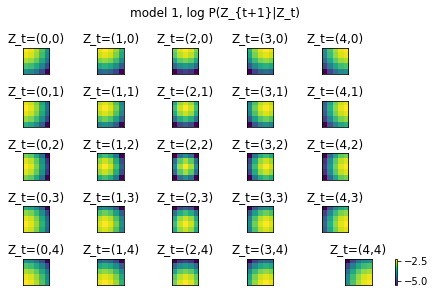

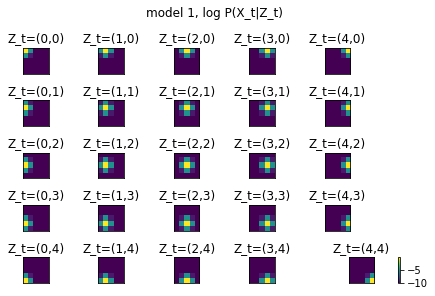

In [514]:
model = Tracker(size=5, # size of the grid world
                alpha=5, # how peaky the observation distribution is
                beta=0.1, # how peaky the transition distribution is
                epsilon=0.001 # probability of garbage sensor reading
)
visualize_spatial_probabilities(model, model.transition_distribution, "model 1, log P(Z_{t+1}|Z_t)")
visualize_spatial_probabilities(model, model.observation_distribution, "model 1, log P(X_t|Z_t)")

# Visualizing a tracker model's probability distributions (model 2)
The following code box will visualize the transition distribution $P(Z_{t+1}|Z_t)$ (top) followed by visualization of $P(X_t|Z_t)$ (bottom) for $\alpha=0.1$, $\beta=5$, $\epsilon=0.5$.

You should see a grid of heatmaps. Each heatmap is labelled with the value of $Z_t$. Each cell in the heatmap corresponds to a different value of either $Z_{t+1}$ (for the transition distribution, top grid) or $X_t$ (for the observation distribution, bottom grid).

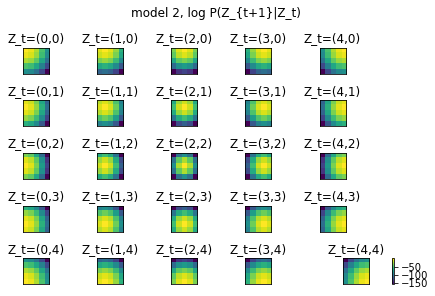

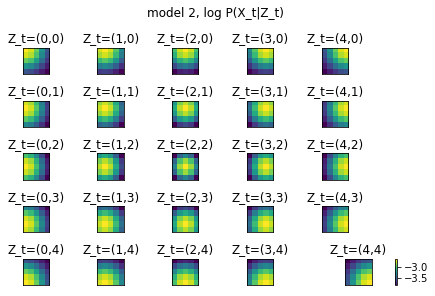

In [515]:
model = Tracker(size=5, # size of the grid world
                alpha=0.1, # how peaky the observation distribution is
                beta=5, # how peaky the transition distribution is
                epsilon=0.5 # probability of garbage sensor reading
)
visualize_spatial_probabilities(model, model.transition_distribution, "model 2, log P(Z_{t+1}|Z_t)")
visualize_spatial_probabilities(model, model.observation_distribution, "model 2, log P(X_t|Z_t)")

# Comparing visualizations

## Question 4.1 (2 pt)
Which parameter(s) cause the observation distributions to differ? Why is model 1's observation distribution more peaky? Pay attention to the scale of the heatmaps in the legends, and remember that these are log probabilities. 

* **Solution: Alpha causes the observation distributions to differ. Alpha controls how likely it is for the sensor to report a location close to the true location. As a result, with a bigger alpha, it is more likely for the observed data to be near the true location, thus model 1's observation distribution is more peaky.** 

## Question 4.2 (2 pt)
Which parameter(s) cause the transition distributions to differ? Which tracker model (1 or 2) has the more diffuse transition probabilities? 

* **Solution: Beta causes the transition distribution to differ. With higher beta, the next state location will be closer to the locaiton at previous state. As a result, for model 2, probability of next state locations being farther away from the previous location becomes really low, which explains the scale of log probability being -150 whlie model 1's scale is around -5 (the bigger the scale, the smaller the probability).** 

# Create an example trajectory on a 10x10 grid
The following code creates an example trajectory that first walks upward along the side of the grid world, and then walks rightward along the top of the grid world. The moving object starts at (0,0). The sensor readings are correct except for the first sensor reading, which erroneously reports the garbage value of (4,7).

In [516]:
size = 10
ground_truth = [(0,t) for t in range(0, size-1) ] + [(t,size-1) for t in range(size) ]
observations = list(ground_truth)
observations[0] = (4,7) # add a garbage sensor reading

# Visualize the inferred trajectory, using both forward and forward/backward, assuming sensor readings are sometimes garbage (epsilon=0.01)

forward has sum of squared error 84.4859010480843
forward_backward has sum of squared error 3.8309602639894536


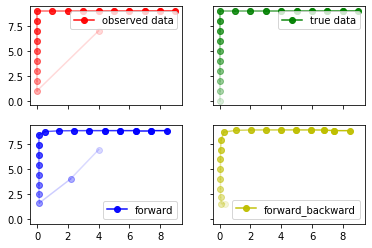

{'forward': 84.4859010480843, 'forward_backward': 3.8309602639894536}

In [517]:
visualize_inferred_trajectory(observations, ground_truth,
                              Tracker(size=10, alpha=1, beta=1, epsilon=0.01))

## Question 4.3 (2 pt)
Why is the forward estimate of the trajectory so incorrect at the beginning, and why does that inaccuracy not occur for forward/backward? 

* **Solution: Because observed data is very different from the true data. Forward estimate takes into account this difference which makes the estimate deviate a lot from true data. However, forward/backward looks at backward estimate, discards the incorrect forward estimate.** 

# Visualize the inferred trajectory, using both forward and forward/backward, assuming sensor readings are never garbage (epsilon=0.0)

forward has sum of squared error 76.38106338793321
forward_backward has sum of squared error 36.30206193140746


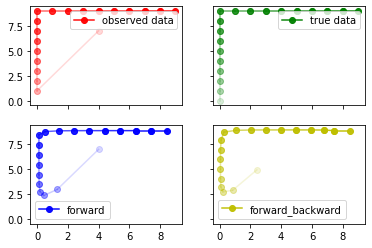

{'forward': 76.38106338793321, 'forward_backward': 36.30206193140746}

In [518]:
visualize_inferred_trajectory(observations, ground_truth,
                              Tracker(size=10, alpha=1, beta=1, epsilon=0.0))

## Question 4.4 (2 pt)
Why is the forward/backward estimate of the trajectory so incorrect at the beginning ($t=1$) when $\epsilon=0$, compared to $\epsilon=0.01$? Why is it still so incorrect at $t=2$?

* **Solution: Since sensor readings are never garbage, meaning the deviated data is also correct. As a reuslt, forward/backward estimate cannot discard the initial jummps, leading to larger error.** 

# Analyze the average error using both the forward and forward/backward algorithm
The below code simulates 100 random trajectories, uses your inference methods to predict the trajectory, and builds analyses the sum of squared errors between the true trajectory and  the predicted trajectory at each time point. We are interested comparing the forward and forward/backward algorithm, so we build a histogram of the difference between the forward/backward error and the forward error (negative numbers mean that forward/backward is better).
The vertical line shows the average of this difference.

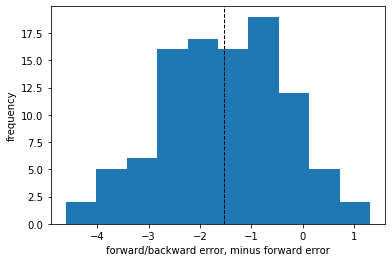

In [519]:
model = Tracker(size=5, # size of the grid world
                alpha=2, # how peaky the observation distribution is
                beta=2, # how peaky the transition distribution is
                epsilon=0.01 # probability of garbage sensor reading
)

    
difference_in_errors = []
for s in range(100):
    np.random.seed(s)
    ground_truth, observations=model.sample_from_model(20)
    errors = analyze_errors(observations, ground_truth, model)

    difference_in_errors.append(errors["forward_backward"]-errors["forward"])

plt.figure()
plt.hist(difference_in_errors)
plt.xlabel("forward/backward error, minus forward error")
plt.ylabel("frequency")
plt.axvline(np.array(difference_in_errors).mean(), color='k', linestyle='dashed', linewidth=1)
plt.show()

## Question 4.5 (4 pt)
You should see that on average forward/backward is more accurate. What is a real world example of tracking a moving object where you would use forward/backward? What is a real world example of tracking a moving object where you would use forward instead? 

* **Solution: When all data is given, we can use forward/backward algorithm to smooth out the observations. However, when data is given in real time, we can only use forward algorithm.** 

# Benchmark the scaling behavior of your inference algorithms
The below code simulates 100 random trajectories of length between 1..100, and benchmarks the runtime of your forward, backward, and forward/backward inference methods.

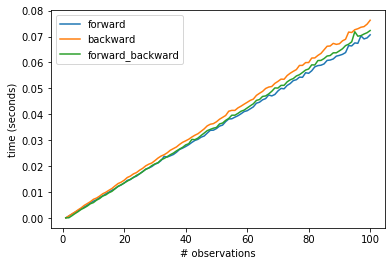

In [520]:
def benchmark_inference(hmm):

    forward_time, backward_time, forward_backward_time = [], [], []
    
    for t in range(1, 100+1):
        ground_truth, observations = hmm.sample_from_model(t)
        hmm.forward_dynamic_programming = {}
        hmm.backward_dynamic_programming = {}

        start_time = time()
        hmm.forward(observations)
        total_time = time() - start_time
        
        forward_time.append(total_time)

        hmm.forward_dynamic_programming = {}
        hmm.backward_dynamic_programming = {}
        start_time = time()
        hmm.backward(observations)
        total_time = time() - start_time
        
        backward_time.append(total_time)

        hmm.forward_dynamic_programming = {}
        hmm.backward_dynamic_programming = {}
        start_time = time()
        hmm.forward_backward(observations, max(1, t//2))
        total_time = time() - start_time
        
        forward_backward_time.append(total_time)

    
    plt.figure()
    plt.plot(np.arange(len(forward_time))+1,
             np.array(forward_time),
             label="forward")
    plt.plot(np.arange(len(backward_time))+1,
             np.array(backward_time),
             label="backward")
    plt.plot(np.arange(len(forward_backward_time))+1,
             np.array(forward_backward_time),
             label="forward_backward")
    plt.legend()
    plt.xlabel("# observations")
    plt.ylabel("time (seconds)")
    plt.show()
benchmark_inference(model)

## Question 4.6 (1 pt)
What is the big-O time complexity of these methods, in terms of the length of the observation sequence, $T$? 

* **Solution: O(T)** 

# Heartrate wakefulness model

You will be working with a HMM for monitoring heart rate (the observed data) and inferring if the patient is awake or asleep (the hidden state). Time is measured in hours, and is discrete. **Heart rate is a continuous random variable.**

The hidden state at each time point is whether the patient is awake or asleep:
$$Z_t\in \{\text{awake}, \text{sleeping}\}$$

The observation at each time point is the heartrate:
$$X_t\in \mathbb{R}$$

Heart rate is distributed according to a normal (Gaussian) distribution, but the mean and standard deviation of this normal distribution depends on the hidden state according to the parameters $\mu_\text{sleep}, \sigma_\text{sleep}, \mu_\text{awake}, \sigma_\text{awake}$:
$$p(X_t|Z_t=\text{sleeping})=\frac{1}{\sigma_\text{sleep}\sqrt{2\pi}}\exp\left(-\frac{1}{2}\left( \frac{X_t-\mu_\text{sleep}}{\sigma_\text{sleep}} \right)^2  \right)$$
$$p(X_t|Z_t=\text{awake})=\frac{1}{\sigma_\text{awake}\sqrt{2\pi}}\exp\left(-\frac{1}{2}\left( \frac{X_t-\mu_\text{awake}}{\sigma_\text{awake}} \right)^2  \right)$$

With probability $p_\text{awaken}$, the patient wakes up after each hour spent sleeping:
$$P(Z_t=\text{awake}|Z_{t-1}=\text{sleeping})=p_\text{awaken}$$
$$P(Z_t=\text{sleeping}|Z_{t-1}=\text{sleeping})=1-p_\text{awaken}$$

With probability $p_\text{sleep}$, the patient falls asleep after each hour spent awake:
$$P(Z_t=\text{sleeping}|Z_{t-1}=\text{awake})=p_\text{sleep}$$
$$P(Z_t=\text{awake}|Z_{t-1}=\text{awake})=1-p_\text{sleep}$$

Apriori, the patient is equally likely to be awake or asleep at the initial time step:
$$P(Z_1=\text{sleeping})=\frac{1}{2}$$
$$P(Z_1=\text{awake})=\frac{1}{2}$$

## Task 5.1 Implement the constructor (2 pt)
Implement the constructor of `SleepHeartRate`. You should calculate and set `transition_distribution` and `initial_distribution`.

## Task 5.2 Implement `logProb_observation_given_state` (2 pt)
Implement the method `logProb_observation_given_state`. Should return the logarithm of the probability density $p(X_t|Z_t)$.

## Task 5.3 Implement `sample_observation_given_state` (2 pt)
Implement the method `sample_observation_given_state` using `np.random.normal`, whose documentation is [here](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)

In [521]:
from math import pi
from math import sqrt

class SleepHeartRate(HMM):
    def __init__(self, mu_sleep, mu_awake, sigma_sleep, sigma_awake,
                 p_awaken, p_sleep):
        """
        mu_sleep: average heart rate, sleeping
        mu_awake: average heart rate, awake
        sigma_sleep: standard deviation of heart rate, sleeping
        sigma_awake: standard deviation of heart rate, awake
        p_awaken: probability of waking up when asleep (per hour)
        p_sleep: probability of falling asleep when awake (per hour)
        """

        self.mu_sleep, self.mu_awake, self.sigma_sleep, self.sigma_awake = \
                       mu_sleep, mu_awake, sigma_sleep, sigma_awake

        state_space = ["sleeping", "awake"]

        # Populate `transition_distribution` so that transition_distribution[s1][s2]=log P(Z_{t+1}=s2|Z_t=s1)
        # s1, s2 should be either "sleeping" or "awake"
        transition_distribution = {}
        
        transition_distribution["sleeping"] = {}
        transition_distribution["awake"] = {}
        transition_distribution["sleeping"]["awake"] = log(p_awaken)
        transition_distribution["sleeping"]["sleeping"] = log(1 - p_awaken)
        transition_distribution["awake"]["sleeping"] = log(p_sleep)
        transition_distribution["awake"]["awake"] = log(1 - p_sleep)
        
        # Populate `initial_state_distribution` such that initial_state_distribution[z]=log P(Z_1=z)
        # z should be either "sleeping" or "awake"
        initial_state_distribution = {}
        
        initial_state_distribution["sleeping"] = log(1/2)
        initial_state_distribution["awake"] = log(1/2)
        
        super().__init__(state_space, transition_distribution, initial_state_distribution)

    def logProb_observation_given_state(self, observation, state):
        """
        calculates log p(observation_t | state_t)
        """
        if (state == "sleeping"):
            return log(exp((-1/2)*(((observation - self.mu_sleep) / self.sigma_sleep)**2))/(self.sigma_sleep*sqrt(2*pi)))
        else:
            return log(exp((-1/2)*(((observation - self.mu_awake) / self.sigma_awake)**2))/(self.sigma_awake*sqrt(2*pi)))

    def sample_observation_given_state(self, state):
        """
        stochastically draws a sample from P(observation_t | state_t)
        """
        if state == "sleeping":
            return np.random.normal(self.mu_sleep, self.sigma_sleep)
        else:
            return np.random.normal(self.mu_awake, self.sigma_awake)

# Analysis code for heart rate model

In [522]:
def analyze_model_predictions(ground_truth, observations, model,
                              visualize=True):
    T = len(observations)
    assert T == len(ground_truth)

    ground_truth = [(gt=="awake")*1. for gt in ground_truth ]

    if visualize:
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time (hr)')
        ax1.set_ylabel('beats per minute', color="b")
        ax1.plot(observations, label="heart rate", color="b")

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('Probability Awake?')  # we already handled the x-label with ax1
        ax2.plot(ground_truth, color="r", label="ground truth")

    errors = {}

    for inference_method in ["forward", "forward_backward"]:
        
        inferred_trajectory = []
        for t in range(1, 1+len(observations)):
            if inference_method == "forward":
                distribution = model.forward(observations[:t])
            elif inference_method == "forward_backward":
                distribution = model.forward_backward(observations, t)
            
            expected_awake = expectation(distribution, lambda state: 1.*(state=="awake"))
            inferred_trajectory.append(expected_awake)
        
        errors[inference_method] = sum( (a-ah)**2 
                                        for a, ah in zip(ground_truth, inferred_trajectory) )
        if visualize:
            print(inference_method, "has sum of squared error", errors[inference_method])
            ax2.plot(inferred_trajectory, label=inference_method)
            

    
    if visualize:
        ax2.legend()
        plt.show()

    return errors

# Create a heart rate model, simulate random data, and run both forward and forward/backward inference

forward has sum of squared error 0.6095274812098443
forward_backward has sum of squared error 0.051685360635295344


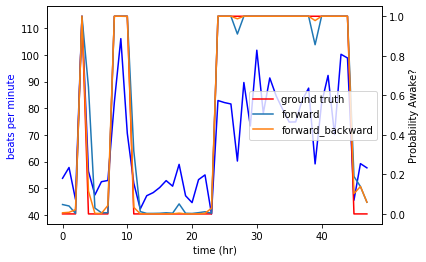

{'forward': 0.6095274812098443, 'forward_backward': 0.051685360635295344}

In [523]:
model = SleepHeartRate(50., # average heart rate, sleeping
                       85., # average heart rate, awake
                       5.,  # standard deviation of heart rate, sleeping
                       15., # standard deviation of heart rate, awake
                       1/8., # probability of waking up when asleep (per hour)
                       1/16. # probability of falling asleep when awake (per hour)
)
np.random.seed(0)
ground_truth, observations=model.sample_from_model(48)
analyze_model_predictions(ground_truth, observations, model)

## Question 6.1 (2 pt)
You should notice at least one long run of the patient being awake. You should also notice that the forward/backward algorithm "jumps the gun" and starts predicting a small probability of wakefulness before actually the patient is awake. Why does this happen?

* **Solution: Because forward/backward uses later data to smooth out the estimate, and since heart rate increases significantly right after, forward/backward takes into account this change and predicts that the patient is awake.** 

# Analyze the average error using both the forward and forward/backward algorithm

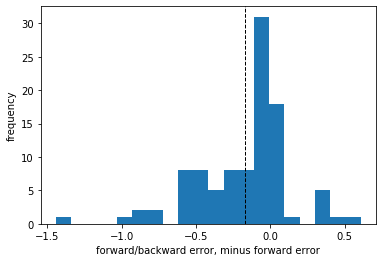

In [524]:
difference_in_errors = []
for s in range(100):
    np.random.seed(s)
    ground_truth, observations=model.sample_from_model(20)
    errors = analyze_model_predictions(ground_truth, observations, model, visualize=False)

    difference_in_errors.append(errors["forward_backward"]-errors["forward"])

plt.figure()
plt.hist(difference_in_errors, bins=20)
plt.xlabel("forward/backward error, minus forward error")
plt.ylabel("frequency")
plt.axvline(np.array(difference_in_errors).mean(), color='k', linestyle='dashed', linewidth=1)
plt.show()

## Question 6.2 (4 pt) 
You should see that on average forward/backward is more accurate. What is a real world example of monitoring heart rate and inferring wakefulness where you would use forward/backward? What is a real world example in this scenario where you would use forward instead? 

* **Solution: When you want more accurate data and has all the data given to you, you want to use forward/backward. When it is real-time data and you want to make sure that a patient is awake, then you would use forward.** 

# A mystery heartrate data set for you to analyze
We have generated a dataset -- but this dataset was generated from a patient with a unknown sleeping heartrate $\mu_\text{sleep}$, which you will have to infer. You can assume
$\sigma_\text{sleep}=5, \mu_\text{awake}=85, \sigma_\text{awake}=15, p_\text{awaken}=1/8, p_\text{sleep}=1/16$.

In [525]:
data = [60.024586292581, 52.3718697759278, 58.80170020585246, 67.11909523460665, 49.8754588478012, 65.14986012024706, 64.24568967142685, 100.04802032130739, 99.8591886252985, 81.5722175046971, 98.15841662729339, 94.52084751694113, 69.18268915795875, 55.57529555049684, 58.5367056334972, 71.17802518532243, 99.45343945778617, 110.00871336445333, 65.87609719134765, 73.49688388469505, 75.14999745087842, 62.83556592039949, 62.24268945549414, 50.64006868902254, 58.68316622316542, 58.76844539881316, 44.70217969599618, 53.20784968688581, 59.6254161863151, 52.73053617276515, 91.46946843489923, 67.56155611791766, 96.00146670782686, 93.16447851190654, 80.33287865068364, 87.14571434632957, 68.70089221350426, 80.60219494419252, 65.94141431130146, 96.37328628188756, 55.11221509740634, 51.2383376346944, 56.65657395145553, 60.49329228703645, 50.386167344456574, 58.28615586781797, 59.037250815880824, 52.947108422631445, 60.45578535635233, 52.80251226623432, 46.75169525578589, 57.22571676296071, 57.52007078129511, 61.60973314211153, 57.34122092576476, 55.89793390034725, 52.01143792919454, 54.980726069973045, 65.70825104401858, 63.02214790547422, 52.383937679940246, 68.46791656760132, 50.5208261485005, 56.596465482996926, 50.46997663314116, 52.18782319819992, 47.75103007441167, 52.16949896921022, 54.72292078866861, 60.91076777688642, 66.73557016014277, 51.788437149295, 47.9436462280157, 58.17907883132434, 58.116637693881735, 74.47731618079851, 72.00486966527343, 71.44157933564942, 51.351651546480895, 48.59728122511345, 48.51399586787, 59.98179888718437, 52.5981219814829, 51.405716498380116, 55.039190955042805, 61.0988621629985, 82.64547636716155, 88.78430366800575, 82.37630040728104, 71.97660245392298, 80.54323815406585, 109.64690694799344, 105.35659649433344, 104.9638969131752, 93.7568541513724, 92.7414755052842, 70.81475837717642, 99.9090452664229, 95.25439425732922, 84.1307548628451, 104.82574081316936, 81.96191274406061, 70.86757270765774, 74.41525964799092, 85.79120242387785, 86.1332117596878, 100.7678626743189, 90.01624012160912, 71.7884040795559, 70.73359696143602, 101.20891696064376, 67.29279483976377, 93.96488663365152, 89.00692866991777, 86.50565099080158, 94.16774529814853, 68.46851293124942, 50.31707874861571, 95.48121164553594, 93.3282366893721, 107.58874005602294, 74.26097918643995, 108.58480530604129, 65.30861662737179, 68.2582493593002, 105.57462867649608, 89.34729173581606, 90.17579760799975, 63.754670231991454, 92.93975937886121, 60.30811678140145, 52.018810065895956, 59.65207940890939, 52.44195306378311, 50.44592662162375, 60.77384356589032, 95.00224569796306, 63.05121895867677, 56.33014259948891, 64.57639305225467, 96.9959748510934, 83.59908000182357, 77.69382924661042, 91.86627110283584, 90.4049936295561, 99.47473788932902, 66.10634898740406, 118.80472907658842, 100.75677458241091, 88.2343328762152, 71.874381123758, 108.6305918624782, 56.70109221698572, 55.44656624810501, 56.864066289101864, 52.4095087326326, 58.11733066507287, 60.38281252479621, 61.122670007845926, 81.03674262733746, 100.2212207602823, 84.09680007042657, 51.25870284998918, 46.22507411109206, 56.931820829501596, 48.204974739723156, 48.86145443933335, 102.57440152785577, 54.05309659353633, 53.34568876774659, 80.7273980640838, 95.59286161718398, 77.88622665296381, 82.40312847033421, 108.00156058411162, 81.90258450297034, 74.1424824500362, 78.42103682348184, 79.49607574109665, 87.94096191621301, 84.05112114463488, 70.03983307606197, 96.88259300600808, 89.19818739612077, 90.34309722760493, 55.85955559057182, 55.561348883547666, 56.21942910813162, 62.65734767196688, 91.81887482725234, 87.14927267146705, 79.60907688266254, 92.8416840816192, 77.54922167157379, 92.38062636596855, 108.69096015624399, 62.46034405153159, 76.87859491768087, 84.1845484157788, 90.13390354517759, 62.41964107344813, 87.89317766344834, 53.95283286979039, 85.74609210621546, 78.8456726565378, 110.96926715915241, 78.68033912662743, 97.30225960808389, 110.74538847351698, 77.71722971641593, 93.01482784188605, 118.1580589938144, 61.16943822368874, 92.40224715512375, 113.88047023655719, 77.42430300423602, 91.3856464843722, 112.1463012616061, 69.20660687884333, 75.2474826323996, 51.67908547001017, 49.496102817092705, 58.35683262150556, 56.597154491810606, 62.576894102206296, 44.382660204462, 55.12491945581128, 59.45083658054802, 45.460929928686205, 59.850429145895575, 52.301922385277955, 50.56818128833715, 54.03572641501221, 53.91969524630194, 51.700234165529395, 55.41156912571518, 63.475033661833294, 58.64556459921754, 51.88113967789142, 47.201143524742875]


# Calculate the prior, likelihood, and posterior over the sleeping heart rate, given the mystery dataset

Assume that we think that the sleeping heart rate is between $40$ and $65$ beats per minute, but that it is probably around $45$.

We are going to quantize the sleeping heart rate:
$\mu_\text{sleep}\in \left\{ 40, 41, 42, \cdots, 65 \right\}$. In the code below, `possible_sleeping_heart_rates` contains the list of possible sleeping heart rates.

In [526]:
possible_sleeping_heart_rates = list(range(40, 65+1))

## Task 7.1 Code the prior over $\mu_\text{sleep}$ (1pt)
Assume this prior distribution over $\mu_\text{sleep}$:
$$P(\mu_\text{sleep})\propto 1\left[ \mu_\text{sleep}\in \left\{ 40, 41, 42, \cdots, 65 \right\} \right]\times\exp\left( -|\mu_\text{sleep}-45| \right)$$
Calculate `log_prior`, which should be a dictionary mapping $\mu_\text{sleep}$ to $\log P(\mu_\text{sleep})$. It should be normalized.

In [527]:
# log_prior[hr] = log P(mu_sleep=hr), whenever hr is a member of possible_sleeping_heart_rates
log_prior = {}

for i in possible_sleeping_heart_rates:
    log_prior[i] = log(exp(-abs(i - 45)))
    
log_prior = norm_log_distribution(log_prior)

# Check that it is normalized
normalizing_constant = log_sum_exp_list(list(log_prior.values()))
if abs(normalizing_constant)>1e-5:
    assert False, f"Your prior over sleeping heart rates is not normalized. Remembered that it should contain log \
    probabilities."

## Task 7.2 Code the likelihood of the mystery data given $\mu_\text{sleep}$ (5pt)
Assume this likelihood:
$$P(X_{1:T}|\mu_\text{sleep})=\sum_{Z_{1:T}}P(X_{1:T}, Z_{1:T}|\mu_\text{sleep}, \sigma_\text{sleep}=5, \mu_\text{awake}=85, \sigma_\text{awake}=15, p_\text{awaken}=1/8, p_\text{sleep}=1/16)
$$
where $X_{1:T}$ is the mystery data, stored in the variable `data`.

Calculate `log_likelihood`, which should be a dictionary mapping $\mu_\text{sleep}$ to $\log P(X_{1:T}|\mu_\text{sleep})$.
You should use the `.marginal_likelihood` method that you defined in the `HMM` class.

In [528]:
# log_likelihood[hr] = log P(data|mu_sleep=hr), whenever hr is a member of possible_sleeping_heart_rates
log_likelihood = {} # implement as part of homework

for i in possible_sleeping_heart_rates:
    model = SleepHeartRate(i, 85., 5., 15., 1/8., 1/16.)
    log_likelihood[i] = model.marginal_likelihood(data)
    
log_likelihood = norm_log_distribution(log_likelihood)

## Task 7.3 Code the posterior over $\mu_\text{sleep}$ given the mystery data (2pt)
By Bayes theorem, the posterior $P(\mu_\text{sleep}|X_{1:T})$ is
$$
P(\mu_\text{sleep}|X_{1:T})\propto P(X_{1:T}|\mu_\text{sleep})P(\mu_\text{sleep})
$$
where $X_{1:T}$ is the mystery data.

Calculate `log_posterior`, which should be a dictionary mapping $\mu_\text{sleep}$ to $\log P(\mu_\text{sleep}|X_{1:T})$. It should be normalized.

In [529]:
# log_posterior[hr] = log P(mu_sleep=hr|data), whenever hr is a member of possible_sleeping_heart_rates
log_posterior = {} # implement as part of homework
for i in possible_sleeping_heart_rates:
    log_posterior[i] = log_sum_exp(log_prior[i], log_likelihood[i])
log_posterior = norm_log_distribution(log_posterior)

# Checked that it is normalized
normalizing_constant = log_sum_exp_list(list(log_posterior.values()))
if abs(normalizing_constant)>1e-5:
    assert False, f"Your posterior over sleeping heart rates is not normalized. Remembered that it should contain \
    log probabilities."

# Visualize the prior, likelihood, and posterior

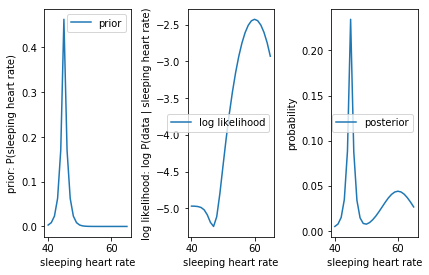

In [530]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False)
ax1.plot(possible_sleeping_heart_rates,
         [exp(log_prior[hr]) for hr in possible_sleeping_heart_rates ],
         label="prior")
ax1.set_xlabel("sleeping heart rate")
ax1.set_ylabel("prior: P(sleeping heart rate)")
ax1.legend()
ax2.plot(possible_sleeping_heart_rates,
         [log_likelihood[hr] for hr in possible_sleeping_heart_rates ],
         label="log likelihood")
ax2.set_xlabel("sleeping heart rate")
ax2.set_ylabel("log likelihood: log P(data | sleeping heart rate)")
ax2.legend()
ax3.plot(possible_sleeping_heart_rates,
         [exp(log_posterior[hr]) for hr in possible_sleeping_heart_rates ],
         label="posterior")
ax3.legend()
ax3.set_xlabel("sleeping heart rate")
ax3.set_ylabel("posterior: P(sleeping heart rate | data)")
plt.ylabel("probability")
plt.tight_layout()
plt.show()

## Question 7.4 (2pt)
What is the most likely value of sleeping heart rate, conditioned on the data? Write a very small amount of code below that will print it out, and compute it from `log_posterior`.

In [531]:
print(str(max(log_posterior, key=log_posterior.get)) + " beats per minute")

45 beats per minute


## Question 7.5 (2pt) 
What is the value of sleeping heart rate that assigns the highest probability to the data? Write a very small amount of code below that will print it out, and compute it from `log_likelihood`.

In [532]:
print(str(max(log_likelihood, key=log_likelihood.get)) + " beats per minute")

60 beats per minute


## Question 7.6 (1pt) 
Why are these previous two values the same, or at least very close? Appeal to general principles of Bayesian inference

* **Solution: They are far, but we can see from the posterior plot that it is clearly affected by the likelihood function, as probability of mu_sleep being 45 went down and there is a peak at around 60. In Bayesian inference, posterior is influenced by both prior and likelihood and as more data is measured, the more likely the posterior follows likelihood distribution. Here, there wasn't enough data collected to push the sleeping heart rate value away from prior belief.** 